# 목표

* 향우 판매량 예측
* 2013년 1월부터 2015년 10월까지 판매 데이터를 기반으로 2015년 11월 판매량 예측

# 준비

In [21]:
import pandas as pd
import glob

p_list=glob.glob("data/*")
p_list

['data\\items.csv',
 'data\\item_categories.csv',
 'data\\sales_train.csv',
 'data\\sample_submission.csv',
 'data\\shops.csv',
 'data\\test.csv']

In [34]:
items = pd.read_csv(p_list[0])
item_categories = pd.read_csv(p_list[1])
sales_train =pd.read_csv(p_list[2])
sample_submission =pd.read_csv(p_list[3])
shops =pd.read_csv(p_list[4])
test =pd.read_csv(p_list[5])

## sales_train 데이터 보기

In [23]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


* 월별 판매량이므로 date 피쳐는 필요 없음
* 꼭 상품가격이 항상 동일 한 것은 아님
* 러시아 데이터 이므로 단위는 루블(ruble)로 예상함
* item_cnt_day 는 상품별 일일 판매량이므로 월간 판매량을 구해야 함

In [24]:
sales_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


* 데이터 수가 169만개 이상이거나 특성 수가 100개보다 많으면 결측값을 출력하지 않는다
    * 이때 show_counts = True를 해주면 출력한다.
* 결측값이 없다
* 데이터 타입이 다양하다.
* 메모리 사용량이 크기때문에 관리가 필요하다.
* 해당 데이터는 시계열 데이터이므로 시간흐름이 중요하다.
    * 따라서 2013년 1월~2015년 9월까지 데이터로 사용하고 10월을 검증데이터로 사용한다.
    * 여러폴드로 나눠 훈련하고 검증하는 OOF 예측은 사용할 수 없다.

## shops 데이터 보기

In [27]:
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


* shop_name 피쳐의 첫번째 단어는 도시 이름을 뜻함
* shop_id는 sales_train 데이터와 같은 피쳐이므로 병합가능

In [28]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


## items 데이터 보기

In [29]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


* 상품명에서는 유용한 정보가 없음, 제거
* item_id 피처또한 sales_train데이터에 존재하는 피처이므로 병합가능

In [30]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


## item_categories 데이터 보기

In [35]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


* item_category_id 를 이용하여 병합가능
* item_category_name 의 첫번째 단어는 대분류이므로 새로운 피쳐 생성

In [36]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


## 테스트 데이터 보기

In [37]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


* 상점id, 상품id을 통해 월간판매량을 예측

## 데이터 병합하기

In [39]:
train = sales_train.merge(shops, on="shop_id", how="left")
train = train.merge(items, on= "item_id", how="left")
train = train.merge(item_categories, on="item_category_id", how="left")

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [40]:
from Myfunc import resumetable
resumetable(train)

데이터 셋 형상 : (2935849, 10)


,피처,데이터 타입,결측값 개수,고윳값 개수,고윳값 1번째,고윳값 2번째,고윳값 3번째,고윳값 4번째,고윳값 5번째
0,date,object,0,1034,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
1,date_block_num,int64,0,34,0,1,2,3,4
2,shop_id,int64,0,60,59,25,24,23,19
3,item_id,int64,0,21807,22154,2552,2554,2555,2564
4,item_price,float64,0,19993,999.0,899.0,1709.05,1099.0,349.0
5,item_cnt_day,float64,0,198,1.0,-1.0,3.0,2.0,4.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТК ""Буденовский"" (пав.К7)","Москва ТК ""Буденовский"" (пав.А2)","Курск ТЦ ""Пушкинский"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),DEEP PURPLE Perihelion: Live In Concert DVD (К...
8,item_category_id,int64,0,84,37,58,56,59,55
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил,Музыка - CD фирменного производства,Музыка - Музыкальное видео,Музыка - CD локального производства


# 데이터 시각화

## 일별 판매량

<AxesSubplot:ylabel='item_cnt_day'>

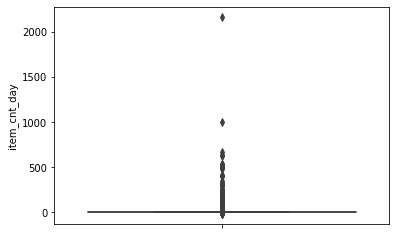

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y="item_cnt_day", data=train)

* 이상치가 과도하게 넓어서 박스 모양이 납작해진 것
* 일별 판매량에서 1000 이상 데이터(이상치) 제거

## 판매가(상품가격)

<AxesSubplot:ylabel='item_price'>

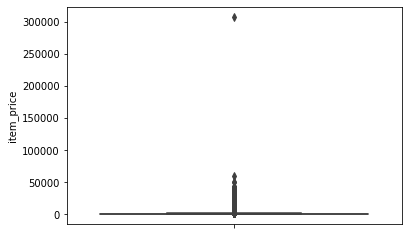

In [42]:
sns.boxplot(data=train, y="item_price")

* 마찬가지로 판매가 50000이상 데이터(이상치) 제거

## 월별 판매량

### 월별 판매량 데이터 - 그룹화

In [61]:
group = train.groupby("date_block_num").agg({"item_cnt_day" : "sum"})
group_month_sum = group.reset_index()
group_month_sum

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


### 월별 판매량 데이터 - 시각화

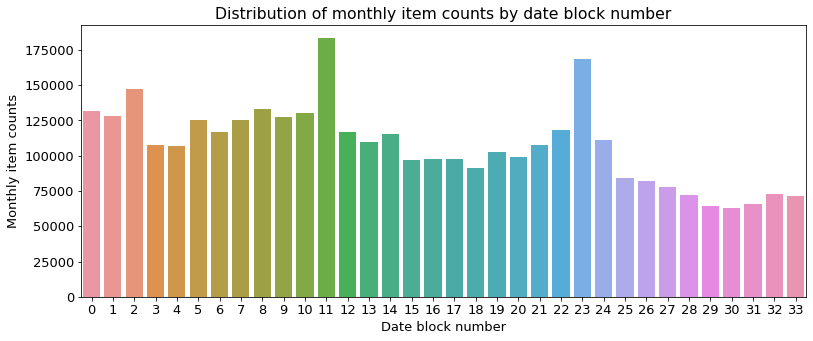

In [63]:
# 옵션
plt.rc("font", size=13)

# 도화지
figure, ax = plt.subplots()
figure.set_size_inches(13, 5)

# 월별 총 상품 판매량 막대 그래프
sns.barplot(x="date_block_num", y="item_cnt_day", data=group_month_sum)

ax.set(title="Distribution of monthly item counts by date block number",
           xlabel="Date block number",
           ylabel="Monthly item counts");

## 상품분류별 판매량

### 상품분류별 총 상품 판매량 데이터

In [70]:
group = train.groupby("item_category_id").agg({"item_cnt_day": "sum"})
group_cat_sum = group.reset_index()
group_cat_sum

,item_category_id,item_cnt_day
0,0,3.0
1,1,2.0
2,2,19597.0
3,3,29807.0
4,4,2407.0
...,...,...
79,79,15830.0
80,80,6136.0
81,81,965.0
82,82,10437.0


### 상품분류별 판매량 시각화

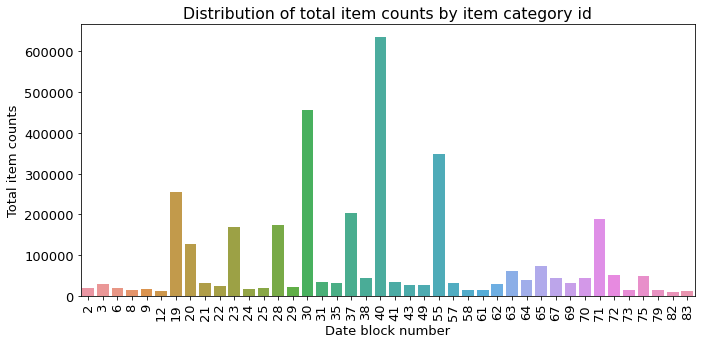

In [71]:
# 도화지
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상품분류별 판매량이 10000이 넘는것만
group_cat_sum = group_cat_sum[group_cat_sum["item_cnt_day"] > 10000]

# 상품분류별 총 상품 판매량 막대 그래프
sns.barplot(x="item_category_id", y="item_cnt_day", data=group_cat_sum)
ax.set(title="Distribution of total item counts by item category id",
      xlabel="Date block number",
      ylabel="Total item counts")
ax.tick_params(axis="x", labelrotation=90)

## 상점별 판매량

In [78]:
group = train.groupby("shop_id").agg({"item_cnt_day" : "sum"})
group_shop_sum = group.reset_index()
group_shop_sum.tail(3)

,shop_id,item_cnt_day
57,57,141107.0
58,58,81734.0
59,59,48993.0


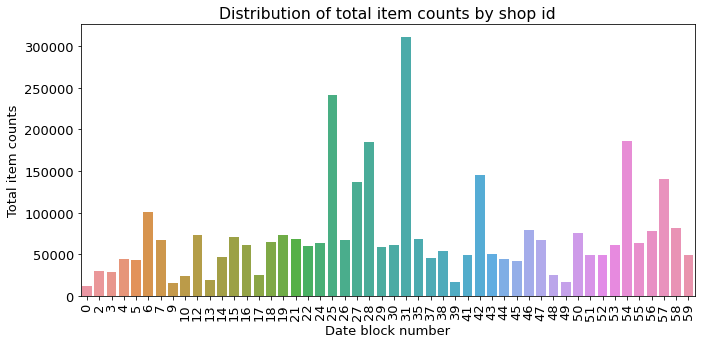

In [80]:
figure, ax = plt.subplots()
figure.set_size_inches(11,5)

# 상점별 판매량 중 10000 이상 데이터
group_shop_sum = group_shop_sum[group_shop_sum["item_cnt_day"] > 10000]

sns.barplot(x="shop_id", y="item_cnt_day", data=group_shop_sum)
ax.set(title="Distribution of total item counts by shop id",
      xlabel="Date block number",
      ylabel="Total item counts")
ax.tick_params(axis="x", labelrotation=90)